In [ ]:
%%capture
%%shell
git clone https://github.com/plarotta/vision-encoder.git
mv /content/vision-encoder/transfer_learner/ /content/
rm -rf /content/vision-encoder/
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zxFDf6wqacM4EfMzLp2YD7kI9g-3KtJk' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zxFDf6wqacM4EfMzLp2YD7kI9g-3KtJk" -O UR5_images_2.zip && rm -rf /tmp/cookies.txt
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TAMiAfoJIyFmvGo5gLzxftRHprF60PzG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TAMiAfoJIyFmvGo5gLzxftRHprF60PzG" -O UR5_positions_2.csv && rm -rf /tmp/cookies.txt
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M16MVlj7pFdaw_JB0iwEe2xFlmeBhgkY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1M16MVlj7pFdaw_JB0iwEe2xFlmeBhgkY" -O UR5_images_3.zip && rm -rf /tmp/cookies.txt
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CDgE1eaYw0R-PdWPWFRXKWpowmSN7pMh' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CDgE1eaYw0R-PdWPWFRXKWpowmSN7pMh" -O UR5_positions_3.csv && rm -rf /tmp/cookies.txt
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1USfNBIeiLhawk7zrxEyCs-UwftRv2m_z' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1USfNBIeiLhawk7zrxEyCs-UwftRv2m_z" -O UR5_images_GodMode.zip && rm -rf /tmp/cookies.txt
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R2qb1b1RnDw8qqCJmGmXYAig18gSGBeb' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R2qb1b1RnDw8qqCJmGmXYAig18gSGBeb" -O UR5_positions_GodMode.csv && rm -rf /tmp/cookies.txt
unzip UR5_images_3.zip
mv UR5_images_3/ images/
rm UR5_images_3.zip
pip install wandb -qq

In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import os
from tqdm import tqdm
from skimage import io
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transfer_learner.source.model import RobotNet
from transfer_learner.source.robot_dataset import RobotImageDataset
from transfer_learner.utils.trainers import train_one_epoch, validate_one_epoch
import wandb
import matplotlib

##Data class

In [ ]:
class RobotImageDataset(Dataset):
    def __init__(self, csv_file: str, root_dir: str, file_names=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[['ImageID','Joint3','Joint4','Joint5', 'Joint6']]
        self.root_dir = root_dir
        if not file_names:
            self.file_names = [
                              "side_view_",
                              "front_view_",
                              "top_view_",
                              "corner1_view_",
                              "corner2_view_",
                              "side_depth_view_",
                              "front_depth_view_",
                              "top_depth_view_",
                              "corner1_depth_view_",
                              "corner2_depth_view_"
                              ]
        else:
            self.file_names = file_names

        #TODO: improve transform so that the final image view is more zoomed in
        self.transform = v2.Compose(
            [
                v2.ToDtype(torch.float32),
                v2.ToTensor(),
                v2.Resize(size=(224, 224), antialias=True),
                v2.Grayscale(),
                v2.ToTensor()
            ])

    def process_images(self, images):
        for im_idx in range(len(images)):
            if len(images[im_idx].shape) > 2:
                images[im_idx] = images[im_idx][:,:,:3]
            images[im_idx] = self.transform(images[im_idx])
        out = torch.cat([im for im in images],dim = 0)
        return(out)

    def __len__(self):
        return(len(self.annotations))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        images = [io.imread(os.path.join(self.root_dir, f + str(idx) + '.png')) for f in self.file_names]
        im_data = self.process_images(images)
        joint_values = self.annotations.iloc[idx, 1:].to_numpy(dtype=float)
        sample = {'images': im_data, 'joint_values': joint_values}
        return sample

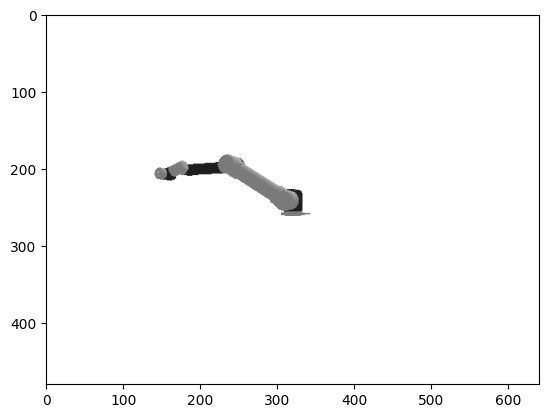

In [ ]:
plt.imshow(io.imread(os.path.join('images', "side_view_" + str(0) + '.png')))

##Model definition

In [ ]:
class RobotNet(nn.Module):
    def __init__(self, n_hidden_units1, n_hidden_units2, n_input_channels, num_inputs=1, multi_input=False, freeze_resnet=False):
        super().__init__()
        self.multi_input = multi_input
        self.in_dim1 = n_hidden_units1
        self.in_dim2 = n_hidden_units2
        self.weights = ResNet18_Weights.DEFAULT

        self.base_model = resnet18(weights=self.weights)
        self.base_layers = list(self.base_model.children())
        self.flatten = nn.Flatten()
        self.num_inputs = num_inputs

        # freeze resnet layers
        if freeze_resnet:
            for idx,child in enumerate(self.base_layers):
              for param in child.parameters():
                param.requires_grad = False


        self.resnet_layers = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            *self.base_layers[1:-1])

        self.linear_output = nn.Sequential(
            nn.Linear(in_features=512*self.num_inputs, out_features=self.in_dim1),
            nn.ReLU(),
            nn.Linear(in_features=self.in_dim1, out_features=self.in_dim2),
            nn.ReLU(),
            nn.Linear(in_features=self.in_dim2, out_features=4)
        )

    def forward(self, inputs):

        if self.multi_input:
            inputs = inputs.transpose(0,1)
            temp = [0 for _ in range(inputs.shape[0])]
            for idx in range(len(inputs)):
                temp[idx] = inputs[idx].unsqueeze(1)
                temp[idx] = self.resnet_layers(temp[idx])
            out = self.linear_output(torch.cat(temp,dim=1).view(-1,512*len(inputs)))
            del temp
        else:
            out = self.resnet_layers(inputs)
            out = self.linear_output(self.flatten(out))

        return out

##Data snooping

In [ ]:
robotdata = RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', multi_input=False)

TypeError: ignored

torch.Size([10, 224, 224])


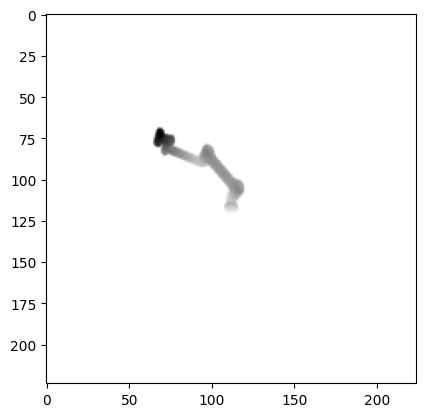

In [ ]:
print(robotdata[0]['images'].shape)
plt.imshow(robotdata[0]['images'][0],cmap='gray')

##Define training and validation loops

In [ ]:

def train_one_epoch(tr_loader, model, loss_func, optimizer, device,feedback=None):
    running_loss = 0.0
    fback = 0.0

    for i, data in enumerate(tr_loader):
        im1 = data['images']
        y = data['joint_values'].float()
        im1,y = im1.to(device), y.to(device)
        optimizer.zero_grad()
        # print('model in',im1.shape)
        preds = model(im1).float()
        preds_hat = torch.cat([torch.sin(preds),torch.cos(preds)],dim=1)
        y_hat = torch.cat([torch.sin(y),torch.cos(y)],dim=1)
        loss = loss_func(preds_hat, y_hat)

        running_loss +=loss.item()
        loss.backward()
        optimizer.step()
        if feedback:
            fback += feedback(preds,y).item()


    train_loss = running_loss/(i+1)
    if feedback:
        return(train_loss,fback/(i+1))
    else:
      return(train_loss)

def validate_one_epoch(val_loader, model, loss_func, optimizer, device,feedback=None):
    running_loss = 0.0
    fback = 0.0

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            im1 = data['images']
            y = data['joint_values'].float()
            im1, y = im1.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(im1).float()
            preds_hat = torch.cat([torch.sin(preds),torch.cos(preds)],dim=1)
            y_hat = torch.cat([torch.sin(y),torch.cos(y)],dim=1)
            loss = loss_func(preds_hat, y_hat)
            running_loss +=loss.item()
            if feedback:
                fback += feedback(preds,y)
    val_loss = running_loss/(i+1)

    if feedback:
        return(val_loss,fback/(i+1))
    else:
      return(val_loss)

def main(model_to_optimize, dataset_to_train_on, experiment_title):
    run = wandb.init(project='vision-encoder', name=experiment_title)
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 32
    EPOCH = 15

    # Check if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    traindata, validdata = random_split(dataset_to_train_on, [0.8,0.2])
    trainloader = DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    validloader = DataLoader(validdata, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

    # Initialize
    model_to_optimize.to(device)
    criterion = nn.MSELoss()
    feedback = nn.MSELoss()
    optimizer = optim.AdamW(model_to_optimize.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= 1000)

    for epoch in range(1,EPOCH):

        tr_loss,t_fback = train_one_epoch(trainloader, model_to_optimize, criterion, optimizer, device, feedback)
        val_loss,v_fback = validate_one_epoch(validloader, model_to_optimize, criterion, optimizer, device, feedback)
        wandb.log(
            {
                "epoch": epoch,
                "train_loss": tr_loss,
                "val_loss": val_loss,
                "train_feedback": t_fback,
                "val_feedback": v_fback
            }
        )
        print(f'epoch: {epoch} | train loss: {tr_loss} | val loss: {val_loss} | "train_feedback": {t_fback} | "val_feedback": {v_fback}')
        scheduler.step()
        # saving to the wandb dir ensures that the model files are accessible on the portal once the run finishes
        torch.save(model_to_optimize.state_dict(),os.path.join(wandb.run.dir, f"model_state_dict_epoch{epoch}.pth"))
    run.finish()
    return(model_to_optimize)



##RUN EXPERIMENT

In [ ]:
# IMAGES_3 DATASET: 5-views + depth
N_DIM1 = 128
N_DIM2 = 32

# MODEL LIST
models = []

In [ ]:
# 5-view + depth, unfrozen resnet, single input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=10, num_inputs=1, multi_input=False, freeze_resnet=False),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","corner1_view_","corner2_view_","side_depth_view_","front_depth_view_","top_depth_view_","corner1_depth_view_","corner2_depth_view_"]),
         experiment_title="5-view + depth, unfrozen resnet, single input")
    )


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.08266630115360021 | val loss: 0.034328977089552654 | "train_feedback": 0.18121327371895313 | "val_feedback": 0.07080022245645523
epoch: 2 | train loss: 0.025173108864575626 | val loss: 0.019715150359958883 | "train_feedback": 0.05164522509276867 | "val_feedback": 0.04015512391924858
epoch: 3 | train loss: 0.01572101266309619 | val loss: 0.017721303398647005 | "train_feedback": 0.03185585130006075 | "val_feedback": 0.036170441657304764
epoch: 4 | train loss: 0.0117872403152287 | val loss: 0.013924810414512953 | "train_feedback": 0.02379277052730322 | "val_feedback": 0.028392786160111427
epoch: 5 | train loss: 0.009991247730329634 | val loss: 0.010972907434084586 | "train_feedback": 0.020140973299741745 | "val_feedback": 0.022249652072787285
epoch: 6 | train loss: 0.008459270399063825 | val loss: 0.008710188473323508 | "train_feedback": 0.017037829468026757 | "val_feedback": 0.01756165362894535
epoch: 7 | train loss: 0.007463180281221867 | val loss: 0.0084

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▃▂▂▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁
val_feedback,█▅▄▃▂▂▂▂▂▂▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁
epoch,14
train_feedback,0.00821
train_loss,0.00409
val_feedback,0.00913
val_loss,0.00455


In [ ]:
# 5-view + depth, frozen resnet, single input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=10, num_inputs=1, multi_input=False, freeze_resnet=True),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","corner1_view_","corner2_view_","side_depth_view_","front_depth_view_","top_depth_view_","corner1_depth_view_","corner2_depth_view_"]),
         experiment_title="5-view + depth, frozen resnet, single input")
    )


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.2104352221786976 | val loss: 0.14596873983031228 | "train_feedback": 0.4704367197751999 | "val_feedback": 0.3218836486339569
epoch: 2 | train loss: 0.13044300800561906 | val loss: 0.12134999367925856 | "train_feedback": 0.2878293316960335 | "val_feedback": 0.2671877145767212
epoch: 3 | train loss: 0.10871923241019249 | val loss: 0.10955069533416203 | "train_feedback": 0.23905471485853194 | "val_feedback": 0.2404295653104782
epoch: 4 | train loss: 0.09608740328252316 | val loss: 0.09802108790193285 | "train_feedback": 0.21030745008587837 | "val_feedback": 0.2139553427696228
epoch: 5 | train loss: 0.08568571011722088 | val loss: 0.0843252016320115 | "train_feedback": 0.18686135348677635 | "val_feedback": 0.1828717440366745
epoch: 6 | train loss: 0.07900956436991692 | val loss: 0.07812630645339451 | "train_feedback": 0.17091537433862686 | "val_feedback": 0.1694224327802658
epoch: 7 | train loss: 0.07070324674248696 | val loss: 0.07988143073660987 | "train_f

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▅▄▃▃▂▂▂▂▂▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁
val_feedback,█▆▅▄▃▂▃▂▂▂▁▁▁▂
val_loss,█▆▅▄▃▂▃▂▂▂▁▁▁▂
epoch,14
train_feedback,0.09615
train_loss,0.04577
val_feedback,0.16598
val_loss,0.07487


In [ ]:
# 5-view + depth, frozen resnet, multi input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=1, num_inputs=10, multi_input=True, freeze_resnet=True),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","corner1_view_","corner2_view_","side_depth_view_","front_depth_view_","top_depth_view_","corner1_depth_view_","corner2_depth_view_"]),
         experiment_title="5-view + depth, frozen resnet, multi input")
    )


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.1661850074827671 | val loss: 0.11298187136177033 | "train_feedback": 0.36915935736894606 | "val_feedback": 0.24852444231510162
epoch: 2 | train loss: 0.10748188772797584 | val loss: 0.0956002472057229 | "train_feedback": 0.2347119083404541 | "val_feedback": 0.20862321555614471
epoch: 3 | train loss: 0.08369513007998466 | val loss: 0.0671756203094172 | "train_feedback": 0.18045118060708046 | "val_feedback": 0.14353568851947784
epoch: 4 | train loss: 0.06763128221035003 | val loss: 0.05565225634546507 | "train_feedback": 0.14423644891381263 | "val_feedback": 0.1181522011756897
epoch: 5 | train loss: 0.0561707762926817 | val loss: 0.05851776241546586 | "train_feedback": 0.11902133059501648 | "val_feedback": 0.12255017459392548
epoch: 6 | train loss: 0.048297909773886205 | val loss: 0.04927649443584775 | "train_feedback": 0.10159493857622147 | "val_feedback": 0.10294868052005768
epoch: 7 | train loss: 0.04452579266577959 | val loss: 0.06045889375465257 | "tr

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▅▄▃▂▂▂▂▂▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁
val_feedback,█▆▄▃▃▂▃▂▁▂▁▁▁▁
val_loss,█▇▄▃▃▃▃▂▁▂▁▁▁▁
epoch,14
train_feedback,0.06065
train_loss,0.02934
val_feedback,0.06923
val_loss,0.03306


In [ ]:


# 5-view - depth, unfrozen resnet, single input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=5, num_inputs=1, multi_input=False, freeze_resnet=False),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","corner1_view_","corner2_view_"]),
         experiment_title="5-view - depth, unfrozen resnet, single input")
    )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.08125744564086199 | val loss: 0.03015783198532604 | "train_feedback": 0.17804857942461969 | "val_feedback": 0.06278222799301147
epoch: 2 | train loss: 0.023245945729315282 | val loss: 0.020832438258424638 | "train_feedback": 0.0475916578322649 | "val_feedback": 0.04281751066446304
epoch: 3 | train loss: 0.016605968672782183 | val loss: 0.01462212944078067 | "train_feedback": 0.033690606497228145 | "val_feedback": 0.029708560556173325
epoch: 4 | train loss: 0.012081636244431138 | val loss: 0.01245577083457084 | "train_feedback": 0.02441945421695709 | "val_feedback": 0.025336630642414093
epoch: 5 | train loss: 0.010640235996805131 | val loss: 0.013784827376228003 | "train_feedback": 0.02147442326694727 | "val_feedback": 0.028053294867277145
epoch: 6 | train loss: 0.00807549094222486 | val loss: 0.00852329961009442 | "train_feedback": 0.016250029260292648 | "val_feedback": 0.01732955314218998
epoch: 7 | train loss: 0.006520148295909166 | val loss: 0.0107596

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▃▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁
val_feedback,█▅▄▃▃▂▃▂▂▁▁▁▁▁
val_loss,█▅▄▃▄▂▃▂▂▁▁▁▁▁
epoch,14
train_feedback,0.00851
train_loss,0.00423
val_feedback,0.00901
val_loss,0.00447


In [ ]:
# 3-view + depth, unfrozen resnet, single input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=6, num_inputs=1, multi_input=False, freeze_resnet=False),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","side_depth_view_","front_depth_view_","top_depth_view_"]),
         experiment_title="3-view + depth, unfrozen resnet, single input")
    )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.0746153653934598 | val loss: 0.03124415481256114 | "train_feedback": 0.16313236026465894 | "val_feedback": 0.06467770785093307
epoch: 2 | train loss: 0.02496453908458352 | val loss: 0.019928534293458575 | "train_feedback": 0.051326098196208474 | "val_feedback": 0.04052486643195152
epoch: 3 | train loss: 0.015498339880257846 | val loss: 0.01681503634308539 | "train_feedback": 0.03146533933281898 | "val_feedback": 0.034183818846940994
epoch: 4 | train loss: 0.011783917868509889 | val loss: 0.011101032193336222 | "train_feedback": 0.02380861100181937 | "val_feedback": 0.02245211787521839
epoch: 5 | train loss: 0.009592463186010718 | val loss: 0.012320310113921998 | "train_feedback": 0.019346045397222043 | "val_feedback": 0.025070564821362495
epoch: 6 | train loss: 0.008580768517218531 | val loss: 0.009244495027122043 | "train_feedback": 0.017291486339643596 | "val_feedback": 0.018657812848687172
epoch: 7 | train loss: 0.007086307062767446 | val loss: 0.0082

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▃▂▂▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁
val_feedback,█▅▄▃▃▂▂▁▁▁▁▂▂▁
val_loss,█▅▄▃▃▂▂▁▁▁▁▂▂▁
epoch,14
train_feedback,0.01092
train_loss,0.00538
val_feedback,0.00995
val_loss,0.00494


In [ ]:
# 3-view + depth, frozen resnet, single input

models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=6, num_inputs=1, multi_input=False, freeze_resnet=True),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","side_depth_view_","front_depth_view_","top_depth_view_"]),
         experiment_title="3-view + depth, frozen resnet, single input")
    )


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.21008536568284034 | val loss: 0.15883671137548627 | "train_feedback": 0.4678200296163559 | "val_feedback": 0.3493802845478058
epoch: 2 | train loss: 0.13786514604091643 | val loss: 0.12408697948096291 | "train_feedback": 0.3043201491832733 | "val_feedback": 0.2710600197315216
epoch: 3 | train loss: 0.11485058018565178 | val loss: 0.1047772564112194 | "train_feedback": 0.2519516904950142 | "val_feedback": 0.22769880294799805
epoch: 4 | train loss: 0.09858816602826119 | val loss: 0.08835156155484063 | "train_feedback": 0.21507199466228485 | "val_feedback": 0.191423699259758
epoch: 5 | train loss: 0.08892015191912651 | val loss: 0.08484197130042409 | "train_feedback": 0.19344906032085418 | "val_feedback": 0.1836070716381073
epoch: 6 | train loss: 0.0833483427464962 | val loss: 0.09443056080786008 | "train_feedback": 0.1806906775832176 | "val_feedback": 0.20448081195354462
epoch: 7 | train loss: 0.07592659606039524 | val loss: 0.0744910751070295 | "train_fee

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▅▄▃▃▂▂▂▂▁▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁
val_feedback,█▆▄▃▃▃▂▂▂▂▁▂▁▁
val_loss,█▆▄▃▃▄▂▂▂▂▁▂▁▁
epoch,14
train_feedback,0.11444
train_loss,0.05396
val_feedback,0.12492
val_loss,0.05846


In [ ]:
# 3-view + depth, frozen resnet, multi input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=1, num_inputs=6, multi_input=True, freeze_resnet=True),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","side_depth_view_","front_depth_view_","top_depth_view_"]),
         experiment_title="3-view + depth, frozen resnet, multi input")
    )


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.18567295882105828 | val loss: 0.12874782972392582 | "train_feedback": 0.413739586353302 | "val_feedback": 0.2815971374511719
epoch: 2 | train loss: 0.11336410200595856 | val loss: 0.09637489477320323 | "train_feedback": 0.24853354680538178 | "val_feedback": 0.209083691239357
epoch: 3 | train loss: 0.0853128491640091 | val loss: 0.08065704557867277 | "train_feedback": 0.18531219160556794 | "val_feedback": 0.17401443421840668
epoch: 4 | train loss: 0.07467657350003719 | val loss: 0.07022709984864507 | "train_feedback": 0.16114021122455596 | "val_feedback": 0.15187403559684753
epoch: 5 | train loss: 0.06926841700077056 | val loss: 0.06964360502740694 | "train_feedback": 0.1494332986474037 | "val_feedback": 0.15032069385051727
epoch: 6 | train loss: 0.06148265980184078 | val loss: 0.06144740887814098 | "train_feedback": 0.13186334803700447 | "val_feedback": 0.13192947208881378
epoch: 7 | train loss: 0.05689669334888458 | val loss: 0.07418102120596265 | "trai

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▅▃▃▂▂▂▂▁▁▁▁▁▁
train_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁
val_feedback,█▅▄▃▃▃▄▂▂▁▁▁▁▁
val_loss,█▅▄▃▃▃▄▂▂▁▁▁▁▁
epoch,14
train_feedback,0.08242
train_loss,0.0392
val_feedback,0.08605
val_loss,0.041


In [ ]:
# 3-view - depth, unfrozen resnet, single input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=3, num_inputs=1, multi_input=False, freeze_resnet=False),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_"]),
         experiment_title="3-view - depth, unfrozen resnet, single input")
    )


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.0720522959381342 | val loss: 0.030351281269556947 | "train_feedback": 0.15700631736218928 | "val_feedback": 0.06289026141166687
epoch: 2 | train loss: 0.02211679551564157 | val loss: 0.01995907055716666 | "train_feedback": 0.0451580178886652 | "val_feedback": 0.040930986404418945
epoch: 3 | train loss: 0.01504675697349012 | val loss: 0.015086287499538489 | "train_feedback": 0.03049678048864007 | "val_feedback": 0.030737627297639847
epoch: 4 | train loss: 0.01185834770835936 | val loss: 0.011049442518029421 | "train_feedback": 0.023955752681940792 | "val_feedback": 0.02235393412411213
epoch: 5 | train loss: 0.010005883956328034 | val loss: 0.01004050268481175 | "train_feedback": 0.020167604848742485 | "val_feedback": 0.020257582888007164
epoch: 6 | train loss: 0.008665574369952083 | val loss: 0.010980597660241146 | "train_feedback": 0.017455433662980795 | "val_feedback": 0.022235402837395668
epoch: 7 | train loss: 0.007421482332982123 | val loss: 0.008076

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▃▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁
val_feedback,█▅▄▃▃▃▂▂▂▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▁▁▁▁▁
epoch,14
train_feedback,0.00718
train_loss,0.00358
val_feedback,0.00821
val_loss,0.00408


In [ ]:
# 1-view + depth, unfrozen resnet, single input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=2, num_inputs=1, multi_input=False, freeze_resnet=False),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["front_view_","front_depth_view_"]),
         experiment_title="1-view + depth, unfrozen resnet, single input")
    )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.1050813327729702 | val loss: 0.05459740414978966 | "train_feedback": 0.233982269346714 | "val_feedback": 0.12017002701759338
epoch: 2 | train loss: 0.04564864294230938 | val loss: 0.043571848274459916 | "train_feedback": 0.10045649254322052 | "val_feedback": 0.09889828413724899
epoch: 3 | train loss: 0.031852530781179667 | val loss: 0.0363630261124363 | "train_feedback": 0.07025467923283576 | "val_feedback": 0.08533964306116104
epoch: 4 | train loss: 0.026563409892842175 | val loss: 0.03490293791724576 | "train_feedback": 0.05837104159966111 | "val_feedback": 0.08347181230783463
epoch: 5 | train loss: 0.022467896170914173 | val loss: 0.029528517379528947 | "train_feedback": 0.04979404670000076 | "val_feedback": 0.07058077305555344
epoch: 6 | train loss: 0.01834269867092371 | val loss: 0.021622332448642406 | "train_feedback": 0.04021044134348631 | "val_feedback": 0.04992461949586868
epoch: 7 | train loss: 0.015543910218402743 | val loss: 0.021619617584205

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▄▃▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁
val_feedback,█▆▅▅▄▂▂▂▂▁▂▁▁▁
val_loss,█▆▅▄▄▂▂▂▂▁▂▁▁▁
epoch,14
train_feedback,0.02173
train_loss,0.00994
val_feedback,0.03751
val_loss,0.01558


In [ ]:
# 1-view + depth, frozen resnet, single input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=2, num_inputs=1, multi_input=False, freeze_resnet=True),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["front_view_","front_depth_view_"]),
         experiment_title="1-view + depth, frozen resnet, single input")
    )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.2231491416990757 | val loss: 0.16206417682151947 | "train_feedback": 0.49950165283679965 | "val_feedback": 0.3596612513065338
epoch: 2 | train loss: 0.145930046916008 | val loss: 0.14041163713212998 | "train_feedback": 0.32371408277750013 | "val_feedback": 0.31078287959098816
epoch: 3 | train loss: 0.13325127109885215 | val loss: 0.1318006809978258 | "train_feedback": 0.29511818653345107 | "val_feedback": 0.2947863042354584
epoch: 4 | train loss: 0.12519664293527602 | val loss: 0.12419836684351876 | "train_feedback": 0.2777219667434692 | "val_feedback": 0.2761501371860504
epoch: 5 | train loss: 0.11737435802817345 | val loss: 0.12217655458620616 | "train_feedback": 0.26001243048906325 | "val_feedback": 0.27349773049354553
epoch: 6 | train loss: 0.11549668139219284 | val loss: 0.11726530156438313 | "train_feedback": 0.2561355906128883 | "val_feedback": 0.2597138583660126
epoch: 7 | train loss: 0.10896122950315476 | val loss: 0.11501218366717535 | "train_f

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▄▃▃▂▂▂▂▂▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁
val_feedback,█▅▅▄▄▃▃▂▂▂▂▁▁▂
val_loss,█▆▅▄▃▃▃▂▂▂▂▁▁▂
epoch,14
train_feedback,0.19622
train_loss,0.08861
val_feedback,0.24692
val_loss,0.10811


In [ ]:
# 1-view + depth, frozen resnet, multi input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=1, num_inputs=2, multi_input=True, freeze_resnet=True),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["front_view_","front_depth_view_"]),
         experiment_title="1-view + depth, frozen resnet, multi input")
    )


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.20996839213371277 | val loss: 0.15364813899237012 | "train_feedback": 0.4700480262041092 | "val_feedback": 0.3419075012207031
epoch: 2 | train loss: 0.14427369874715806 | val loss: 0.13079283776737394 | "train_feedback": 0.3214510316848755 | "val_feedback": 0.2909909784793854
epoch: 3 | train loss: 0.12871327006816863 | val loss: 0.13268981471894278 | "train_feedback": 0.28624582475423815 | "val_feedback": 0.2998344600200653
epoch: 4 | train loss: 0.12040698701143265 | val loss: 0.11696436752875645 | "train_feedback": 0.26807440239191055 | "val_feedback": 0.26097190380096436
epoch: 5 | train loss: 0.11242638692259789 | val loss: 0.11418336310556956 | "train_feedback": 0.2502204164564609 | "val_feedback": 0.2550511658191681
epoch: 6 | train loss: 0.10509683991968631 | val loss: 0.11033539426705194 | "train_feedback": 0.2338296331167221 | "val_feedback": 0.24662522971630096
epoch: 7 | train loss: 0.10118405331671237 | val loss: 0.10374500354131062 | "train

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▄▄▃▃▂▂▂▂▂▁▁▁▁
train_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁
val_feedback,█▆▆▄▄▄▃▃▂▁▂▁▁▂
val_loss,█▆▆▄▄▄▃▃▂▂▂▁▁▂
epoch,14
train_feedback,0.17307
train_loss,0.07804
val_feedback,0.20276
val_loss,0.09155


In [ ]:

# 1-view - depth, unfrozen resnet, single input
models.append(
    main(RobotNet(N_DIM1, N_DIM2, n_input_channels=1, num_inputs=1, multi_input=False, freeze_resnet=False),
         RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["front_view_"]),
         experiment_title="1-view - depth, unfrozen resnet, single input")
    )


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


cuda:0
epoch: 1 | train loss: 0.10495999111235142 | val loss: 0.06317230083403133 | "train_feedback": 0.2350211624801159 | "val_feedback": 0.1410452425479889
epoch: 2 | train loss: 0.049437615387141705 | val loss: 0.045428713576661214 | "train_feedback": 0.11013778549432754 | "val_feedback": 0.10166344791650772
epoch: 3 | train loss: 0.037341251026839016 | val loss: 0.035965231971608266 | "train_feedback": 0.08327492823451757 | "val_feedback": 0.08025573194026947
epoch: 4 | train loss: 0.0287548732124269 | val loss: 0.0328314799283232 | "train_feedback": 0.06496463251113892 | "val_feedback": 0.0751873180270195
epoch: 5 | train loss: 0.02466659816727042 | val loss: 0.030571376195266134 | "train_feedback": 0.05607229101657867 | "val_feedback": 0.07263754308223724
epoch: 6 | train loss: 0.021246824411675334 | val loss: 0.023533217727191864 | "train_feedback": 0.0476228182464838 | "val_feedback": 0.055056143552064896
epoch: 7 | train loss: 0.018105107229202985 | val loss: 0.023962979751919

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
train_feedback,█▄▃▃▂▂▂▂▁▂▁▁▁▁
train_loss,█▄▃▂▂▂▂▂▁▂▁▁▁▁
val_feedback,█▅▄▃▃▂▂▂▂▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁
epoch,14
train_feedback,0.01848
train_loss,0.00835
val_feedback,0.04092
val_loss,0.01672


In [ ]:
multi_model = RobotNet(128,32, n_input_channels=6)
multi_model.load_state_dict(torch.load('/content/model_state.pth'))

<All keys matched successfully>

In [ ]:
robotdata = RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', multi_input=False)
loader = DataLoader(robotdata, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [ ]:
running_loss = 0.0
fback = 0.0
device = 'cpu'
loss_f = nn.MSELoss()
feed = nn.MSELoss()

with torch.no_grad():
    for i, data in enumerate(loader):
        im1 = data['images']
        y = data['joint_values'].float()
        preds = multi_model(im1).float()
        preds_hat = torch.cat([torch.sin(preds),torch.cos(preds)],dim=1)
        y_hat = torch.cat([torch.sin(y),torch.cos(y)],dim=1)
        loss = loss_f(preds_hat, y_hat)
        running_loss +=loss.item()
        feed_l = feed(preds,y)
        fback += feed_l.item()
        print(loss.item(),feed_l.item())
        print(f'gt: {y}, pred: {preds}')
        input()

val_loss = running_loss/(i+1)
feed_loss = fback/(i+1)

In [ ]:
%%shell


##DATA VIZ

###loss plots

In [ ]:
train_dat = pd.read_csv('/content/train.csv')
train_dat = train_dat.loc[:,~train_dat.apply(lambda x: x.duplicated(),axis=1).all()].copy()
val_dat = pd.read_csv('/content/val.csv')
val_dat = val_dat.loc[:,~val_dat.apply(lambda x: x.duplicated(),axis=1).all()].copy()

In [ ]:
[i[:-13] for i in list(train_dat.columns)[1:]]

['1-view - depth, unfrozen resnet, single input',
 '1-view + depth, frozen resnet, multi input',
 '1-view + depth, frozen resnet, single input',
 '1-view + depth, unfrozen resnet, single input',
 '3-view - depth, unfrozen resnet, single input',
 '3-view + depth, frozen resnet, multi input',
 '3-view + depth, frozen resnet, single input',
 '3-view + depth, unfrozen resnet, single input',
 '5-view - depth, unfrozen resnet, single input',
 '5-view + depth, frozen resnet, multi input',
 '5-view + depth, frozen resnet, single input',
 '5-view + depth, unfrozen resnet, single input']

In [ ]:
len(train_dat)

14

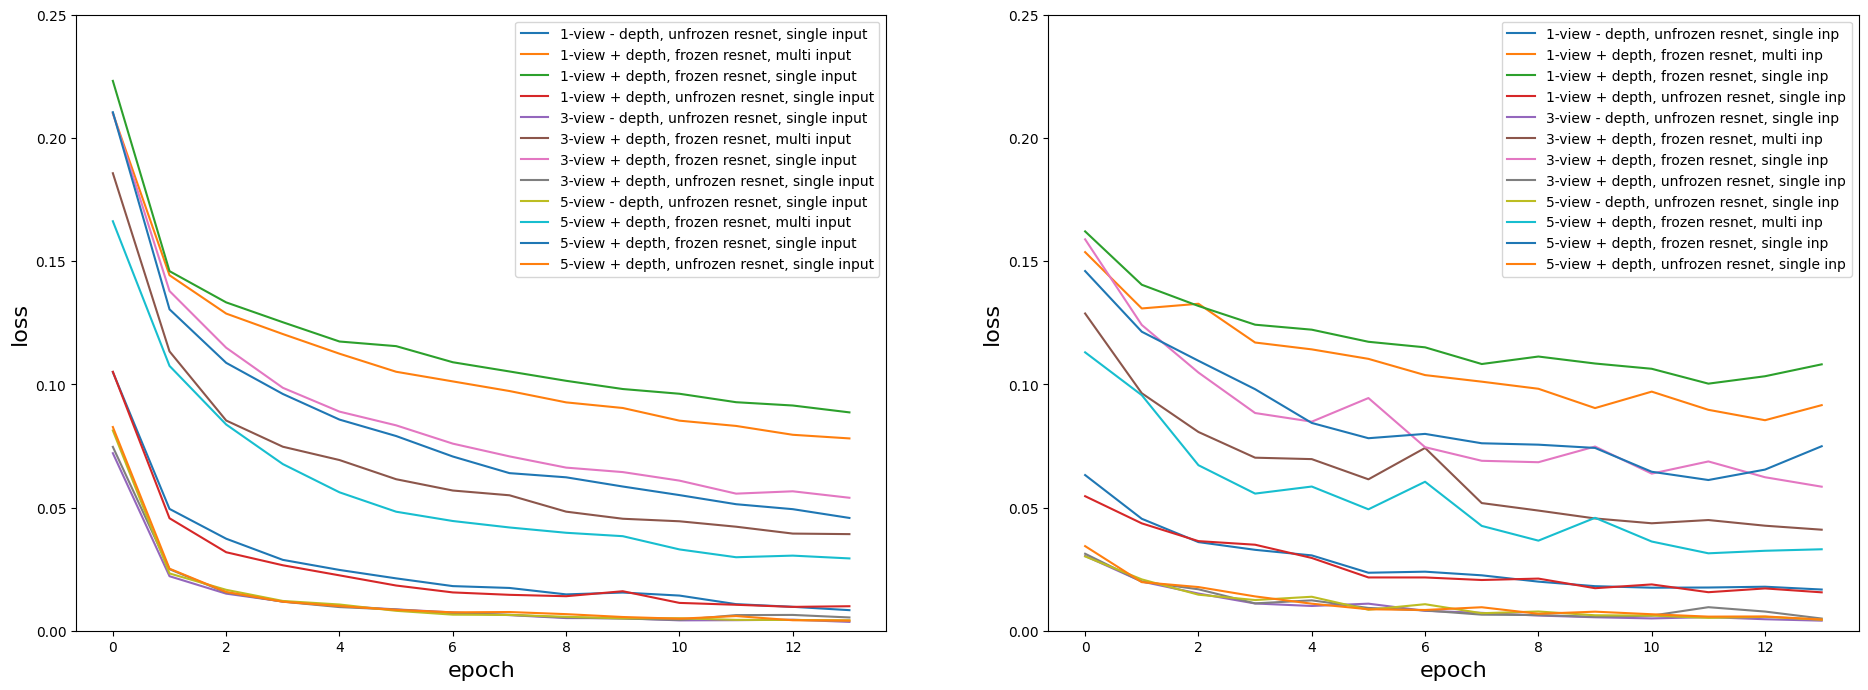

In [ ]:
matplotlib.rcParams.update({'font.size': 10})

fig,axs = plt.subplots(1,2, figsize=(23, 8))

tr = train_dat.to_numpy()[:,1:]
va = val_dat.to_numpy()[:,1:]
tr_names = [i[:-13] for i in list(train_dat.columns)[1:]]
va_names = [i[:-13] for i in list(val_dat.columns)[1:]]
for idx in range(12):
    axs[0].plot(tr[:,idx], label=tr_names[idx])
    axs[1].plot(va[:,idx], label=va_names[idx])


axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[0].set_ylim([0,.25])
axs[0].title.set_fontsize(16)
axs[0].xaxis.label.set_fontsize(16)
axs[0].yaxis.label.set_fontsize(16)


axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].legend()
axs[1].set_ylim([0,.25])
axs[1].title.set_fontsize(16)
axs[1].xaxis.label.set_fontsize(16)
axs[1].yaxis.label.set_fontsize(16)
# axs[1].xticklabels().set_fontsize(13)
# axs[1].get_legend().get_texts().set_fontsize(13)



# plt.rc('font', size=10)          # controls default text sizes
# plt.rc('axes', titlesize=15)     # fontsize of the axes title
# plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.rc('figure', titlesize=20)  # fontsize of the figure title

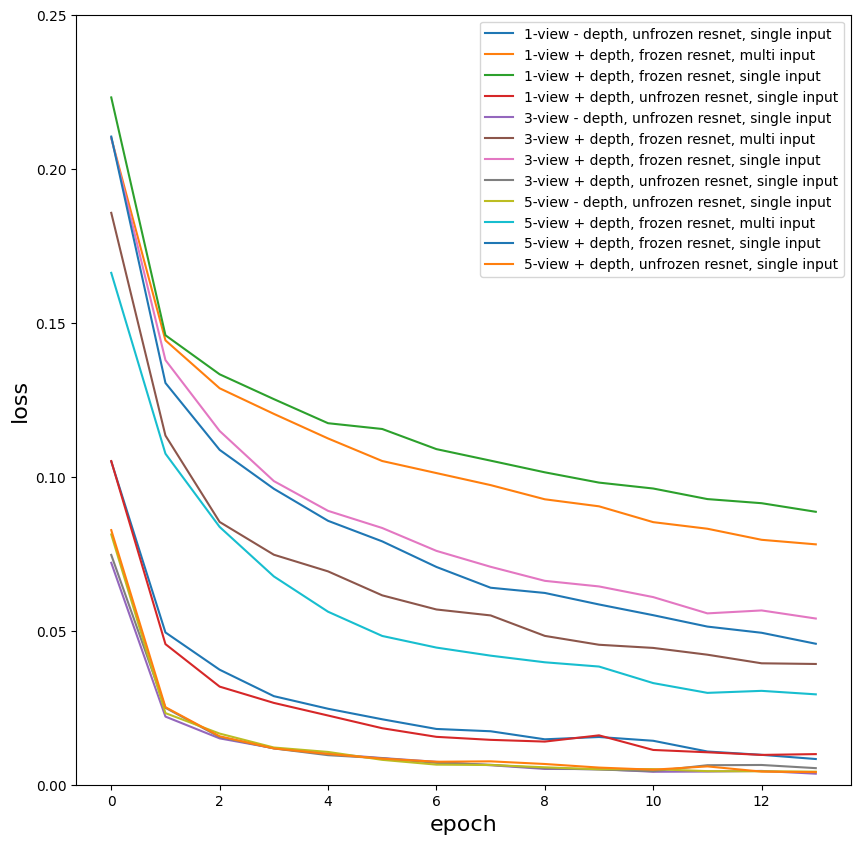

In [ ]:
fig,axs = plt.subplots(1,1, figsize=(10, 10))

tr = train_dat.to_numpy()[:,1:]
va = val_dat.to_numpy()[:,1:]
tr_names = [i[:-13] for i in list(train_dat.columns)[1:]]
va_names = [i[:-13] for i in list(val_dat.columns)[1:]]
for idx in range(12):
    axs.plot(tr[:,idx], label=tr_names[idx])
    # axs[1].plot(va[:,idx], label=va_names[idx])


axs.set_xlabel('epoch')
axs.set_ylabel('loss')
axs.legend()
axs.set_ylim([0,.25])
axs.title.set_fontsize(16)
axs.xaxis.label.set_fontsize(16)
axs.yaxis.label.set_fontsize(16)
fig.savefig('trainloss.png')

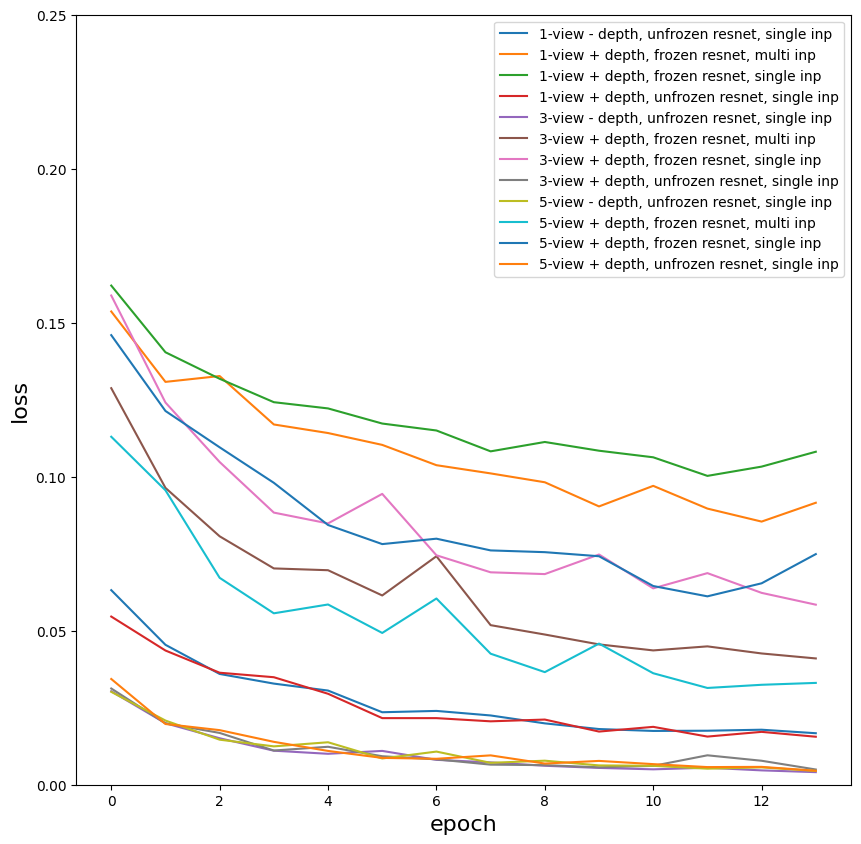

In [ ]:
fig,axs = plt.subplots(1,1, figsize=(10, 10))

tr = train_dat.to_numpy()[:,1:]
va = val_dat.to_numpy()[:,1:]
tr_names = [i[:-13] for i in list(train_dat.columns)[1:]]
va_names = [i[:-13] for i in list(val_dat.columns)[1:]]
for idx in range(12):
    axs.plot(va[:,idx], label=va_names[idx])
    # axs[1].plot(va[:,idx], label=va_names[idx])


axs.set_xlabel('epoch')
axs.set_ylabel('loss')
axs.legend()
axs.set_ylim([0,.25])
axs.title.set_fontsize(16)
axs.xaxis.label.set_fontsize(16)
axs.yaxis.label.set_fontsize(16)
fig.savefig('valloss.png')

In [ ]:
axs[0].savefig('lossplots.png')

AttributeError: ignored

In [ ]:
b = train_dat.loc[:,~train_dat.apply(lambda x: x.duplicated(),axis=1).all()].copy()


###accuracy

In [ ]:
#models to test
N_DIM1 = 128
N_DIM2 = 32

model_dir_paths = [
      "5-view + depth, unfrozen resnet, single input",
      "5-view + depth, frozen resnet, single input",
      "5-view + depth, frozen resnet, multi input",
      "5-view - depth, unfrozen resnet, single input",
      "3-view + depth, unfrozen resnet, single input",
      "3-view + depth, frozen resnet, single input",
      "3-view + depth, frozen resnet, multi input",
      "3-view - depth, unfrozen resnet, single input",
      "1-view + depth, unfrozen resnet, single input",
      "1-view + depth, frozen resnet, single input",
      "1-view + depth, frozen resnet, multi input",
      "1-view - depth, unfrozen resnet, single input"
]

model_datas = [
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","corner1_view_","corner2_view_","side_depth_view_","front_depth_view_","top_depth_view_","corner1_depth_view_","corner2_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","corner1_view_","corner2_view_","side_depth_view_","front_depth_view_","top_depth_view_","corner1_depth_view_","corner2_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","corner1_view_","corner2_view_","side_depth_view_","front_depth_view_","top_depth_view_","corner1_depth_view_","corner2_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","corner1_view_","corner2_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","side_depth_view_","front_depth_view_","top_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","side_depth_view_","front_depth_view_","top_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_","side_depth_view_","front_depth_view_","top_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["side_view_","front_view_","top_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["front_view_","front_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["front_view_","front_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["front_view_","front_depth_view_"]),
    RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', file_names = ["front_view_"]),

]

model_nets = [
    RobotNet(N_DIM1, N_DIM2, n_input_channels=10, num_inputs=1, multi_input=False, freeze_resnet=False),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=10, num_inputs=1, multi_input=False, freeze_resnet=True),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=1, num_inputs=10, multi_input=True, freeze_resnet=True),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=5, num_inputs=1, multi_input=False, freeze_resnet=False),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=6, num_inputs=1, multi_input=False, freeze_resnet=False),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=6, num_inputs=1, multi_input=False, freeze_resnet=True),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=1, num_inputs=6, multi_input=True, freeze_resnet=True),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=3, num_inputs=1, multi_input=False, freeze_resnet=False),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=2, num_inputs=1, multi_input=False, freeze_resnet=False),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=2, num_inputs=1, multi_input=False, freeze_resnet=True),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=1, num_inputs=2, multi_input=True, freeze_resnet=True),
    RobotNet(N_DIM1, N_DIM2, n_input_channels=1, num_inputs=1, multi_input=False, freeze_resnet=False),

]

In [ ]:
device = 'cpu'
all_mse = {}
for idx in tqdm(range(len(model_dir_paths))):
    multi_model = model_nets[idx]
    multi_model.load_state_dict(torch.load('/content/models/' + model_dir_paths[idx] + '/' + 'model_state_dict_epoch14.pth',map_location=torch.device('cpu')),)
    loader = DataLoader(model_datas[idx], batch_size=1, shuffle=True)

    pred_tens = torch.tensor(np.zeros((500,4)))
    gt_tens = torch.tensor(np.zeros((500,4)))
    multi_model.eval()

    with torch.no_grad():
        for i, data in enumerate(loader):
            if i == 500:
                break
            y = data['joint_values'].float()
            preds = multi_model(data['images']).float()
            pred_tens[i,:] = preds[0]
            gt_tens[i,:] = y[0]

    joints = []
    for joint in range(4):
        joints.append(F.mse_loss(pred_tens[:,joint], gt_tens[:,joint]).item())
    all_mse[model_dir_paths[idx]] = {'joint1':joints[0],
                                     'joint2':joints[1],
                                     'joint3':joints[2],
                                     'joint4':joints[3]}


100%|██████████| 12/12 [23:52<00:00, 119.37s/it]


In [ ]:
all_mse

{'5-view + depth, unfrozen resnet, single input': {'joint1': 0.0037709388451289084,
  'joint2': 0.0025003030397156853,
  'joint3': 0.0033760743316351618,
  'joint4': 0.01264103149841205},
 '5-view + depth, frozen resnet, single input': {'joint1': 0.02537495061899578,
  'joint2': 0.01940167856190568,
  'joint3': 0.05243276358980641,
  'joint4': 0.40119885013899576},
 '5-view + depth, frozen resnet, multi input': {'joint1': 0.7763176276667548,
  'joint2': 0.8513969113141671,
  'joint3': 1.1248363895271736,
  'joint4': 1.0207038087128948},
 '5-view - depth, unfrozen resnet, single input': {'joint1': 0.002023843037878777,
  'joint2': 0.0022733863403556344,
  'joint3': 0.0033152346310577415,
  'joint4': 0.009377244914756343},
 '3-view + depth, unfrozen resnet, single input': {'joint1': 0.00493261477895453,
  'joint2': 0.002327421812007363,
  'joint3': 0.0045708411560442495,
  'joint4': 0.010024304289773063},
 '3-view + depth, frozen resnet, single input': {'joint1': 0.024438827453390353,
  

In [ ]:
model_dir_paths

['5-view + depth, unfrozen resnet, single input',
 '5-view + depth, frozen resnet, single input',
 '5-view + depth, frozen resnet, multi input',
 '5-view - depth, unfrozen resnet, single input',
 '3-view + depth, unfrozen resnet, single input',
 '3-view + depth, frozen resnet, single input',
 '3-view + depth, frozen resnet, multi input',
 '3-view - depth, unfrozen resnet, single input',
 '1-view + depth, unfrozen resnet, single input',
 '1-view + depth, frozen resnet, single input',
 '1-view + depth, frozen resnet, multi input',
 '1-view - depth, unfrozen resnet, single input']

<ipython-input-95-b69cc0591d7b>:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[idx].set_ylim([0,2.5])


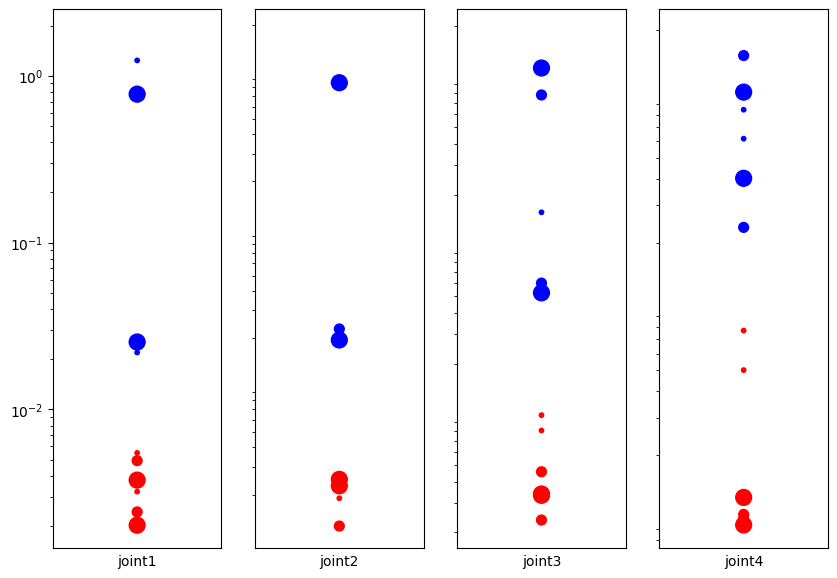

In [ ]:
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker


fig,axs = plt.subplots(1,4, figsize=(10, 7))

c = []
s = []
for i in range(len(model_dir_paths)):
    if 'unfrozen' in model_dir_paths[i]:
        c.append('r')
    else:
        c.append('b')
    if "1-view" in model_dir_paths[i]:
        s.append(10)
    elif "3-view" in model_dir_paths[i]:
        s.append(50)
    else:
        s.append(130)


for idx in range(4):
    # c = ['r' if 'unfrozen' in model_dir_paths[i] else 'b' for i in range(len(model_dir_paths))]

    joint = 'joint' + str(idx+1)
    axs[idx].scatter([0]*len(model_dir_paths), [all_mse[model_dir_paths[i]][joint] for i in range(len(model_dir_paths))], color= c, s = s)
    axs[idx].set_yscale('log')
    axs[idx].set_ylim([0,2.5])
    axs[idx].set_xlabel(joint)
    axs[idx].xaxis.set_major_locator(ticker.NullLocator())
    if idx >0:
      axs[idx].yaxis.set_major_locator(ticker.NullLocator())
fig.savefig('joint_plot.png', )

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f1d945cdc90>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f1d945cec20>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f1d945cf670>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f1d982f71f0>}

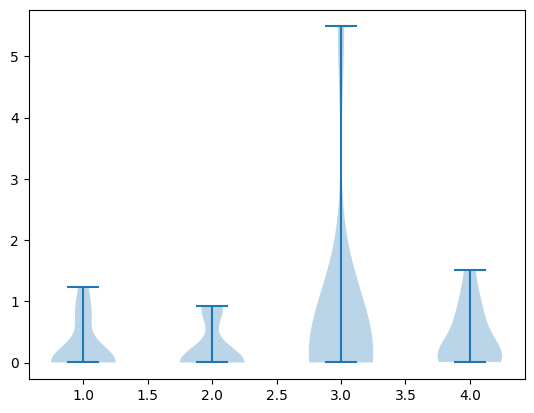

In [ ]:
plt.violinplot([ [all_mse[model_dir_paths[i]]['joint' + str(joint+1)] for i in range(len(model_dir_paths))] for joint in range(4)])